In [1]:
useCuda = False

x0_y0_r_xrf_yrf torch.Size([100, 1]) torch.Size([100, 1]) torch.Size([100, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])
torch.Size([100, 3, 32, 32]) torch.Size([100, 1000, 2])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size

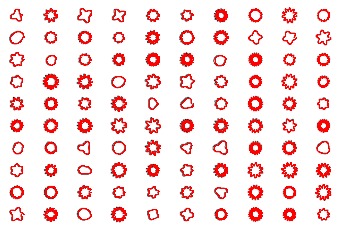

In [2]:
import torch
import numpy as np
import pylab as plt
from skimage import filters
import math

from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler


global numpoints
numpoints = 1000
side = 32

rows = torch.zeros(32,32)
columns = torch.zeros(32,32)


for i in range(32):
    columns[:,i] = i
    rows[i,:] = i


def donut_matrix(length = 10):
    radiusMax = side /3
    w = 1
    sigmas = [None, 1]
    
    canvas = torch.zeros((length,side, side))
    r0 = torch.tensor(np.random.uniform(side/4, side/3, length))

    radii = torch.zeros((length,numpoints))
    radii[:, :] = r0.unsqueeze(1)
    
    ind = [x for x in range(numpoints)]

    theta = torch.FloatTensor(ind)
    theta *= math.pi*2.0/(float)(numpoints)
    
    for i in range(1,length):
        a = np.random.uniform(1.0,3.0)*torch.sin(np.random.uniform(20.0)*theta+np.random.uniform(1000.0))
        radii[i,:] += a
        
    assert torch.min(radii)>0
    rmaxs = radii.max(axis = 1)[0]
    pmins = rmaxs+1.0
    pmaxs = side-rmaxs-1.0
    x0 = np.random.uniform(pmins,pmaxs)
    y0 = np.random.uniform(pmins,pmaxs)
    x0[:]=side/2
    y0[:]=side/2
    x0 = torch.tensor(x0)
    y0 = torch.tensor(y0)
    
    x0 = x0.unsqueeze(1)
    y0 = y0.unsqueeze(1)
    #radii = torch.from_numpy(radii)
    xrfactors = torch.cos(theta).unsqueeze(0)
    yrfactors = torch.sin(theta).unsqueeze(0)
    
    print('x0_y0_r_xrf_yrf',x0.shape,y0.shape,radii.shape,xrfactors.shape,yrfactors.shape)

    x = (x0+(xrfactors*radii))
    y = (y0+(yrfactors*radii))
    
    assert x.shape == (length,numpoints)
    assert y.shape == (length,numpoints)
    assert torch.sum(x[x>(side-1)])==0 
    assert torch.sum(x[x<0])==0 
    assert torch.sum(y[y>(side-1)])==0 
    assert torch.sum(y[y<0])==0 
    
    points = torch.zeros(length,numpoints,2)
    for l in range(length):
        canvas[l,y[l,:].type(torch.LongTensor),x[l,:].type(torch.LongTensor)]=1.0
        points[l,:,0] = x[l,:]#modified for lstm discriminator
        points[l,:,1] = y[l,:]#modified for lstm discriminator 
    
    
    return {
        'canvas': canvas, 
        'points':points.type(torch.FloatTensor)}

def plot_one(img,xs,ys,i=0):
  print(img.shape,xs.shape,ys.shape)
  plt.subplot(10,10,i+1)
  plt.imshow(img, cmap=plt.cm.gray_r)
  predres = 1000
  s = [.001 for x in range(predres)]
  assert len(s) == predres
  c = ['red' for x in range(predres)]
  assert len(c) == predres
  plt.plot(xs.cpu().numpy(),ys.cpu().numpy(),',-', color='red',ms=.3,lw=.3)
  #plt.gca().add_artist(ascatter)
  plt.axis('off')

def plot_all( sample = None, model = None, labels = None, i = 0):
    
    #make prediction
    #plot one prediction
    #or plot one ground truth
    if model != None:
        with torch.no_grad():
            global numpoints
            
            print('preloss')
            if useCuda:
                loss, out = mse_vit(sample.cuda(),labels.cuda(),model=model,ret_out = True)
            else:
                loss, out = mse_vit(sample,labels,model=model,ret_out = True)
            print('loss',loss)
            
            for i in range(100):
              img = sample[i,0,:,:].squeeze().cpu().numpy()
              X = out[i,:1000,0]
              Y = out[i,-1000:,1]
              plot_one(img,X,Y,i=i)
              
            
    else:
      print(sample.shape,labels.shape)
      for i in range(100):
        img = sample[i,0,:,:].squeeze().cpu().numpy()
        X = labels[i,:,0]
        Y = labels[i,:,1]
        
        plot_one(img,X,Y,i=i)
          
        
class DonutDataset(torch.utils.data.Dataset):
    """Donut dataset."""
    def __init__(self, length = 10):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.length = length
        self.values = donut_matrix(length)
        assert self.values['canvas'].shape[0] == self.length
        assert self.values['points'].shape[0] == self.length
        
        count = 0
        for i in range(self.length):
          a = self[i]
          c = a[0][0,:,:]
          for el in a[1]:
            y,x = (int)(el[1]),(int)(el[0])
            
            if x < side-2 and x > 2 and y < side-2 and y > 2: 
              if c[y,x] != 1 and \
                c[y+1,x] != 1 and c[y+1,-1+x] != 1 and c[y+1,1+x] != 1 and \
                c[y-1,x] != 1 and c[y,-1+x] != 1 and c[y,1+x] != 1:
                count+=1
        assert count ==0
    def __len__(self):
        return self.length


    def __getitem__(self, idx):
        canvas = self.values["canvas"]
        
        canvas = canvas[idx,:,:]

        #assert canvas.shape == (side,side) or canvas.shape == (len(idx))
        
        points = self.values["points"]
        points = points[idx,:]
        if len(canvas.shape) == 2:
          canvas = torch.stack([canvas,canvas,canvas],dim=0)
        else:
          canvas = torch.stack([canvas,canvas,canvas],dim=1)
        
        return canvas, points
    
    @staticmethod
    def displayCanvas(title,loader, model):
        #model.setBatchSize(batch_size = 1)
        
        for sample, labels in loader:
          plot_all(sample = sample,model=model, labels = labels)
          break
        plt.savefig(title,dpi=600)

dataset = DonutDataset(length = 100)

mini_batch = 100
loader_demo = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=2)
DonutDataset.displayCanvas('donut.png',loader_demo, model = None)


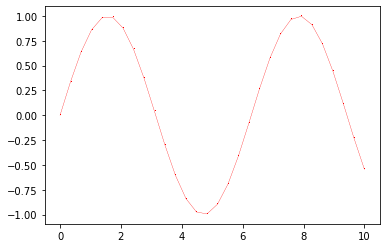

In [3]:
x = np.linspace(0, 10, 30)
y = np.sin(x)

plt.plot(x, y, ',-', color='red',ms=.3,lw=.3);


In [4]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 100
train_dataset = DonutDataset(length = 100*2)
loader_train = data.DataLoader(
    train_dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=train_dataset),
    num_workers=4)


x0_y0_r_xrf_yrf torch.Size([200, 1]) torch.Size([200, 1]) torch.Size([200, 1000]) torch.Size([1, 1000]) torch.Size([1, 1000])


In [5]:
!pip install vit-pytorch


In [6]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 32,
    patch_size = 4,
    num_classes = 2000,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

v = torch.nn.Sequential(
    v,
    torch.nn.Sigmoid()
)

img = torch.randn(100, 3, 32, 32)

preds = v(img) # (1, 1000)


In [7]:
print(preds.shape)

torch.Size([100, 2000])


In [8]:

#model = resnet18(pretrained=False,progress=True, num_classes = 2000).cuda()
#model = wide_resnet101_2(pretrained=False,progress=True, num_classes = 2000).cuda()
if useCuda:
    model = v.cuda()
else:
    model = v

In [9]:

def mse_vit(input, target,model=None,ret_out = False):
  out = model(input)
  out = out.reshape(target.shape)#64, 1000, 2
  out = out*32.0
  #print('mse_cnn',out.shape,target.shape)
  if not ret_out:
    return torch.mean((out-target)**2)
  else:
    return torch.mean((out-target)**2),out
  

In [12]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.0001, betas = (.9,.999))#ideal


In [13]:
for epoch in range(1):
  for x,y in loader_train:
    optimizer.zero_grad()
    if useCuda:
        x = x.cuda()
        y = y.cuda()
    loss = mse_vit(x,y,model=model)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)
    #print(out.shape)
  
  

epoch 0 loss tensor(12.2951, grad_fn=<MeanBackward0>)


In [14]:
optimizer = torch.optim.Adam(model.parameters(),lr = 0.00001, betas = (.9,.999))#ideal


In [15]:
for epoch in range(1):
  for x,y in loader_train:
    optimizer.zero_grad()
    if useCuda:
        x = x.cuda()
        y = y.cuda()
    loss = mse_vit(x,y,model=model)
    loss.backward()
    optimizer.step()
  print('epoch',epoch,'loss',loss)
    #print(out.shape)
  
  

epoch 0 loss tensor(8.8685, grad_fn=<MeanBackward0>)


In [ ]:
model = model.eval()
#dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('vit-training-1.png',loader_train, model = model)


preloss
loss tensor(7.5745)
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torch.Size([1000])
(32, 32) torch.Size([1000]) torc

In [ ]:
from torch.utils import data
from torch.utils.data import DataLoader, TensorDataset, RandomSampler

mini_batch = 100
dataset = DonutDataset(length = 100)
loader_test = data.DataLoader(
    dataset, 
    batch_size=mini_batch,
    sampler=RandomSampler(data_source=dataset),
    num_workers=4)


In [ ]:
#model = model.eval()
for x,y in loader_test:
    if useCuda:
        x = x.cuda()
        y = y.cuda()
    loss = mse_vit(x,y,model=model)
    print('validation loss',loss)
    break


#need to avoid overfitting
#https://discuss.pytorch.org/t/inject-dropout-into-resnet-or-any-other-network/66322/2

In [ ]:
#model = model.eval()
#dataset = DonutDataset(length = 100)
DonutDataset.displayCanvas('vit-test-set-1.png',loader_test, model = model)
